In [1]:
import os
import glob
import sys
import pickle
import random 
import numpy as np
import src.data as d
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

## Transition times and the first extracted feature

In [2]:
all_bearings = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17']

In [4]:
bucket_size = 20
path = os.getcwd()
bearings_X = glob.glob(os.path.join("data", "LDM", "fft", "*")) 

X_200 = {} #when we have 200 features
y = {}
for b_adr in bearings_X:
    b_name = b_adr[-7:-4]
    X_200[b_name] = np.load(b_adr)
    y[b_name] = d.rul_calculator(X_200[b_name].shape[0])

if int(bucket_size) == 200:
    X = X_200
else:
    X = {}
    for b in X_200.keys():
        X[b] = np.array([np.max(t, axis=1) for t in np.split(X_200[b], int(bucket_size), axis=1)]).transpose()

In [11]:
for test_bearing in all_bearings: 
    #load transition times
    with open(os.path.join("transition_times", "bucket_size_20", "seed_0", test_bearing + ".pkl"), 'rb') as f:
        transition_times = pickle.load(f)
        
    
    train_bearings = np.setdiff1d(all_bearings, test_bearing).tolist()
    X_scaled = d.my_scaler(X, train_bearings)

    plt.figure(figsize=(10,5))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 28
    plt.xlabel("Measurement Cycle")
    plt.ylabel("First Extracted Feature") 
    # plt.ylabel(r'$X_t^{(i)}(0)$') 
    plt.ylim([0,1]) 
    plt.plot(np.arange(X_scaled[test_bearing].shape[0]), X_scaled[test_bearing][:,0], label="First Extracted Feature")
    plt.axvline(transition_times[test_bearing], c='r', label="Transition Time")
    # plt.title(test_bearing)
    # plt.legend()  
    os.makedirs(os.path.join("plots", "transition_times"), exist_ok=True) 
    plt.savefig(os.path.join("plots", "transition_times", test_bearing+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
    plt.close()

# Estimation plots

In [13]:
from matplotlib.ticker import PercentFormatter

In [16]:
model = "HistGradientBoostingRegressor"
seed = str(10)
bucket_size = str(20)
n_bins = str(20)
scenarios = ["Scenario 1", "Scenario 2", "Scenario 3"]

for test_bearing in all_bearings:
    #We need this for the x-axis of the plot
    with open(os.path.join("transition_times", "bucket_size_20", "seed_0", test_bearing + ".pkl"), 'rb') as f:
        transition_times = pickle.load(f)
        
    plt.figure(figsize=(10,5))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 28
    plt.xlabel("Measurement Cycle")
    plt.ylabel("RUL")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # plt.yaxis.set_major_formatter(mtick.PercentFormatter())
    # plt.title(new_names[j])
    for scenario in ["op_ignore", "op_norm", "op_feature"]: 
        if scenario=="op_norm":
            scenario = os.path.join(scenario, "bin_number_"+n_bins)
        y_hat = np.load(os.path.join("all_yhats", model, test_bearing, "bucket_size_"+bucket_size, scenario, "seed_"+seed, "y_hat.npy"))
        y = d.rul_calculator(y_hat.shape[0])        
        plt.plot(np.arange(transition_times[test_bearing],X[test_bearing].shape[0]), y_hat, label=scenario)
    
    plt.plot(np.arange(transition_times[test_bearing],X[test_bearing].shape[0]), y, label="Ground truth")
    # plt.legend()
    os.makedirs(os.path.join("plots", "RUL_estimations", model), exist_ok=True) 
    plt.savefig(os.path.join("plots", "RUL_estimations", model, test_bearing+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
    plt.close()

# TABLES

In [18]:
for test_bearing in all_bearings:
    with open(os.path.join("transition_times", "bucket_size_20", "seed_0", test_bearing + ".pkl"), 'rb') as f:
        transition_times = pickle.load(f)
    
    
    total_life = X[test_bearing].shape[0] 
    tt = transition_times[test_bearing]
    text = test_bearing + " & " + str(total_life) + " & " + str(tt)
    
    for model in ["HistGradientBoostingRegressor", "RandomForestRegressor"]:
        b_mean = []
        b_std = []
        for scenario in ["op_ignore", "op_norm", "op_feature"]: 
            if scenario=="op_norm":
                scenario = os.path.join(scenario, "bin_number_"+n_bins)
            mae = []
            for s in np.arange(10,110,10):
                y_hat = np.load(os.path.join("all_yhats", model, test_bearing, "bucket_size_"+bucket_size, scenario, "seed_"+seed, "y_hat.npy"))
                y = d.rul_calculator(y_hat.shape[0])
                mae.append(mean_absolute_error(y, y_hat))
            
            b_mean.append(np.mean(mae))
            b_std.append(np.std(mae))

        
        
        for i in range(3):
            if b_mean[i] == np.min(b_mean): 
                text += " & " + r"\textbf{%.2f}" %(b_mean[i]*100) 
            else: 
                text += " & " + "%.2f" %(b_mean[i]*100) 
    print(text+ r"\\")

B01 & 377 & 208 & \textbf{18.14} & 22.77 & 19.96 & 18.00 & 21.51 & \textbf{17.17}\\
B02 & 1116 & 998 & 29.43 & \textbf{25.25} & 27.41 & 28.74 & \textbf{26.10} & 27.24\\
B03 & 614 & 562 & 24.05 & \textbf{21.52} & 25.83 & 25.24 & \textbf{21.90} & 24.17\\
B04 & 1114 & 452 & 15.23 & 19.25 & \textbf{15.02} & 14.90 & 19.56 & \textbf{14.07}\\
B05 & 572 & 560 & 44.40 & 41.11 & \textbf{36.34} & 42.20 & 37.28 & \textbf{34.75}\\
B06 & 12965 & 12853 & \textbf{11.73} & 16.00 & 13.55 & 13.50 & 15.64 & \textbf{11.85}\\
B07 & 6393 & 6205 & 44.36 & \textbf{42.54} & 42.82 & 43.63 & 44.78 & \textbf{43.09}\\
B08 & 1827 & 1219 & \textbf{15.42} & 17.98 & 15.70 & 18.18 & 19.08 & \textbf{17.51}\\
B09 & 1813 & 253 & 20.85 & 23.19 & \textbf{17.19} & 21.41 & 22.95 & \textbf{19.67}\\
B10 & 3224 & 2679 & 19.48 & \textbf{18.62} & 23.13 & 23.87 & \textbf{18.79} & 26.11\\
B11 & 1953 & 931 & 23.94 & 23.85 & \textbf{22.79} & 25.22 & \textbf{24.28} & 24.66\\
B12 & 767 & 154 & \textbf{15.80} & 17.26 & 17.43 & 16.90 & \te

# Bucket-size effect

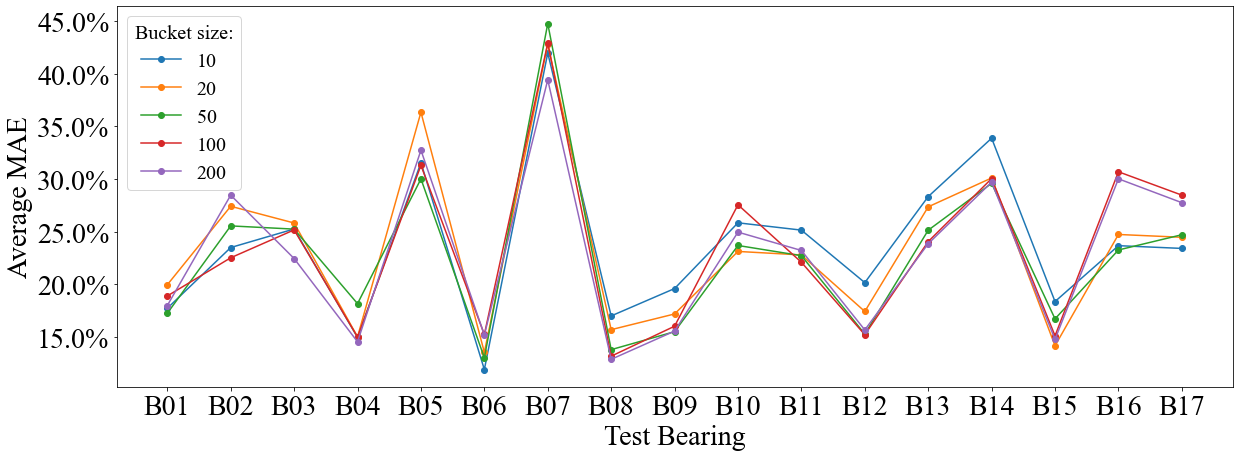

In [52]:
model = "HistGradientBoostingRegressor"
n_bins = str(20)
scenario = "op_feature"  
if scenario=="op_norm":
    scenario = os.path.join(scenario, "bin_number_"+n_bins)
plt.figure(figsize=(20,7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 28
plt.xlabel("Test Bearing")
plt.ylabel("Average MAE")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
for bucket_size in ["10", "20", "50", "100", "200"]:
    mae_bucket_size = []
    for test_bearing in all_bearings:
        mae_b = []
        for s in np.arange(10,110,10):
            y_hat = np.load(os.path.join("all_yhats", model, test_bearing, "bucket_size_"+bucket_size, scenario, "seed_"+seed, "y_hat.npy"))    
            y = d.rul_calculator(y_hat.shape[0])
            mae_b.append(mean_absolute_error(y, y_hat))
        mae_bucket_size.append(np.mean(mae_b))
    plt.plot(mae_bucket_size, label=bucket_size, marker='o')
    plt.xticks(np.arange(len(all_bearings)), all_bearings)
plt.rcParams["font.size"] = 20
plt.legend(title="Bucket size:", loc="upper left")
os.makedirs(os.path.join("plots", "bucket_size_effect", scenario), exist_ok=True) 
plt.savefig(os.path.join("plots", "bucket_size_effect", scenario, "bucket_size_effect.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
# plt.close()

# Bin_number effect

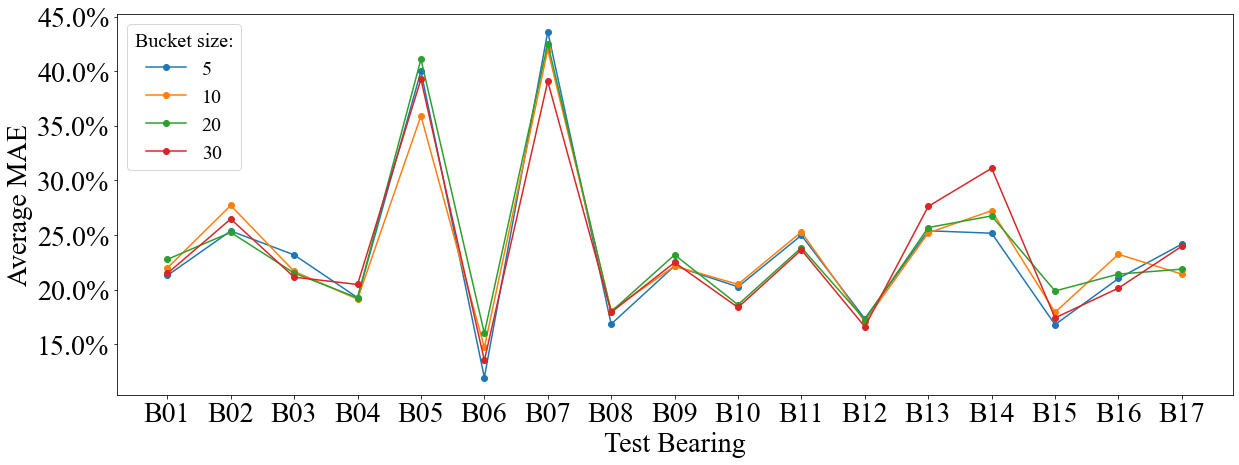

In [49]:
model = "HistGradientBoostingRegressor"
bucket_size = str(20) 
plt.figure(figsize=(20,7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 28
plt.xlabel("Test Bearing")
plt.ylabel("Average MAE")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
for n_bins in ["5", "10", "20", "30"]:
    scenario = os.path.join("op_norm", "bin_number_"+n_bins)
    mae_bin = []
    for test_bearing in all_bearings:
        mae_b = []
        for s in np.arange(10,110,10):
            y_hat = np.load(os.path.join("all_yhats", model, test_bearing, "bucket_size_"+bucket_size, scenario, "seed_"+seed, "y_hat.npy"))    
            y = d.rul_calculator(y_hat.shape[0])
            mae_b.append(mean_absolute_error(y, y_hat))
        mae_bin.append(np.mean(mae_b))
    plt.plot(mae_bin, label=n_bins, marker='o')
    plt.xticks(np.arange(len(all_bearings)), all_bearings)
plt.rcParams["font.size"] = 20
plt.legend(title="Bucket size:", loc="upper left")
os.makedirs(os.path.join("plots", "bin_num_effect"), exist_ok=True) 
plt.savefig(os.path.join("plots", "bin_num_effect", "bin_num_effect.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
# plt.close()